In [19]:
# --- NB10: Imports & run config ---
import json, re, math, warnings
from pathlib import Path

import numpy as np
import pandas as pd
from joblib import load

# Paths
DATA_DIR = Path("data")
ART_DIR  = Path("artifacts")
FIG_DIR  = Path("reports/figures")
for p in [DATA_DIR, ART_DIR, FIG_DIR]: p.mkdir(parents=True, exist_ok=True)

# Trading policy
FEE_BPS = 5.0          # one-way (apply on flips)
SLIPPAGE_BPS = 0.0     # placeholder (not applied unless you want to)
TAU_DEFAULT = 0.59     # fallback if no artifact

# Load τ from artifacts if present (prefer backtest_summary.json, else threshold.json)
TAU = TAU_DEFAULT
bs = ART_DIR / "backtest_summary.json"
thr = ART_DIR / "threshold.json"
try:
    if bs.exists():
        j = json.loads(bs.read_text(encoding="utf-8"))
        TAU = float(j["models"]["LR"]["tau"])
    elif thr.exists():
        tj = json.loads(thr.read_text(encoding="utf-8"))
        if isinstance(tj, dict):
            if "threshold" in tj: TAU = float(tj["threshold"])
            elif "LR" in tj and "tau" in tj["LR"]: TAU = float(tj["LR"]["tau"])
            elif "tau" in tj: TAU = float(tj["tau"])
except Exception as e:
    warnings.warn(f"Could not read tau from artifacts, using default {TAU_DEFAULT}. Error: {e}")

print(f"Daily inference config → τ={TAU:.3f} | fee={FEE_BPS} bps | slippage={SLIPPAGE_BPS} bps")


Daily inference config → τ=0.590 | fee=5.0 bps | slippage=0.0 bps


In [20]:
# --- Load df_nb02 (CSV/Parquet) & ensure 'date' and 'y' ---
df_path = DATA_DIR/"df_nb02.parquet" if (DATA_DIR/"df_nb02.parquet").exists() else DATA_DIR/"df_nb02.csv"
df = pd.read_parquet(df_path) if df_path.suffix==".parquet" else pd.read_csv(df_path, parse_dates=["date"])
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

# Label if missing: next-day direction
label_col = next((c for c in ["y","target","label","y_next_up"] if c in df.columns), None)
if label_col is None:
    price_col = next((c for c in ["ret1","close","Close","Adj Close","adj_close"] if c in df.columns), None)
    if price_col is None: raise RuntimeError("No label & no price/ret1 columns to derive it.")
    if price_col == "ret1":
        df["y"] = (df["ret1"].shift(-1) > 0).astype(int)
    else:
        df["y"] = (pd.Series(df[price_col]).pct_change().shift(-1) > 0).astype(int)
elif label_col != "y":
    df["y"] = df[label_col].astype(int)

print(f"Rows: {len(df)}  |  Span: {df['date'].min().date()} → {df['date'].max().date()}  |  Pos rate: {df['y'].mean():.3f}")


Rows: 2686  |  Span: 2015-02-06 → 2025-10-10  |  Pos rate: 0.530


In [21]:
# --- Load LR, scaler, and leak-safe feature list ---
lr = load(ART_DIR/"lr.joblib")
scaler = load(ART_DIR/"scaler.joblib") if (ART_DIR/"scaler.joblib").exists() else None

feat_cols = json.loads((ART_DIR/"feature_list.json").read_text(encoding="utf-8"))
LEAK_WORDS = re.compile(r"(next|lead|t\+|ahead|future|target|label)$", re.I)
BAD = {"y","ret_next","y_next_up","target","label"}

feat_cols = [c for c in feat_cols if c in df.columns and c not in BAD and not LEAK_WORDS.search(c)]
feat_cols = [c for c in feat_cols if pd.api.types.is_numeric_dtype(df[c])]
assert "y" not in feat_cols and "ret_next" not in feat_cols, "Leak columns slipped into features."

print(f"Features: {len(feat_cols)}  |  First 5: {feat_cols[:5]}")


Features: 16  |  First 5: ['close', 'high', 'low', 'macd', 'macd_signal']


In [22]:
# --- Predict probabilities for all available dates (idempotent) ---
X = df[feat_cols].fillna(0.0).to_numpy()
if scaler is not None:
    Xs = scaler.transform(X)
else:
    Xs = X

p = lr.predict_proba(Xs)[:,1]
sig = (p >= TAU).astype(int)

# Build base signals frame
price_col = next((c for c in ["close","Close","Adj Close","adj_close"] if c in df.columns), None)
if price_col is None: raise RuntimeError("No close price column found for returns.")

signals = pd.DataFrame({
    "date": df["date"],
    "close": df[price_col].astype(float),
    "prob": p,
    "signal": sig
})
# Realized next-day returns if known
signals["ret_next"] = signals["close"].pct_change().shift(-1)

# Trades: apply fee on position flips
signals["signal_prev"] = signals["signal"].shift(1).fillna(0).astype(int)
signals["flip"] = (signals["signal"] != signals["signal_prev"]).astype(int)
fee = FEE_BPS / 10000.0
signals["strategy_ret"] = signals["signal"] * signals["ret_next"] - signals["flip"] * fee
signals["strategy_ret"] = signals["strategy_ret"].fillna(0.0)
signals["equity"] = (1 + signals["strategy_ret"]).cumprod()

signals.tail(5)


,date,close,prob,signal,ret_next,signal_prev,flip,strategy_ret,equity
2681,2025-10-06,256.690002,0.536564,0,-0.000818,0,0,-0.0,1.217782
2682,2025-10-07,256.480011,0.542238,0,0.006160,0,0,0.0,1.217782
2683,2025-10-08,258.059998,0.528984,0,-0.015578,0,0,-0.0,1.217782
2684,2025-10-09,254.039993,0.561558,0,-0.034522,0,0,-0.0,1.217782
2685,2025-10-10,245.270004,0.565084,0,NaN,0,0,0.0,1.217782


In [23]:
# --- Save / update artifacts ---
sig_path = DATA_DIR/"signals.csv"
signals.to_csv(sig_path, index=False)

paper = {
    "tau": float(TAU),
    "fee_bps": float(FEE_BPS),
    "slippage_bps": float(SLIPPAGE_BPS),
    "as_of": str(signals["date"].max().date()),
    "rows": int(len(signals)),
    "equity": float(signals["equity"].iloc[-1]),
    "turnover": float((signals["flip"].rolling(252, min_periods=1).sum() / 252.0).iloc[-1]),
}
(ART_DIR/"paper_trade.json").write_text(json.dumps(paper, indent=2), encoding="utf-8")

print("Saved:", sig_path, "| artifacts/paper_trade.json")
print("As of:", paper["as_of"], "| Equity ×:", round(paper["equity"], 4), "| 1y turnover:", round(paper["turnover"], 4))


Saved: data\signals.csv | artifacts/paper_trade.json
As of: 2025-10-10 | Equity ×: 1.2178 | 1y turnover: 0.0873


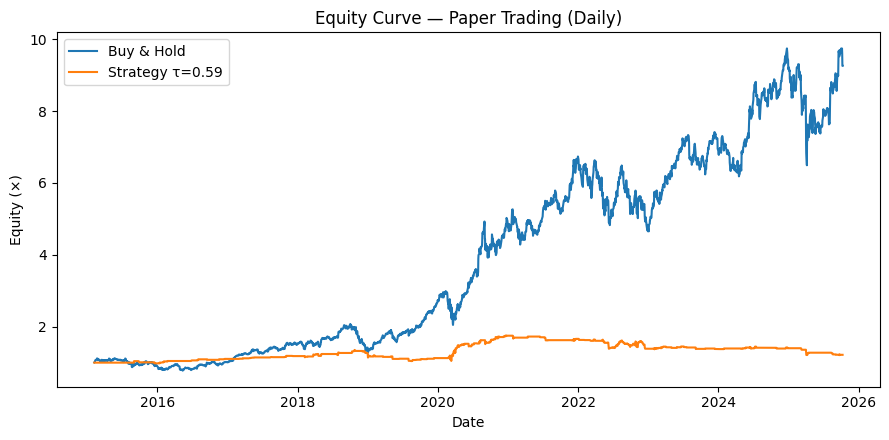

Saved figure: reports\figures\equity_curve_live.png


In [24]:
# --- Equity curve (strategy vs buy & hold) ---
import matplotlib.pyplot as plt

bh = (1 + signals["ret_next"].fillna(0.0)).cumprod()

plt.figure(figsize=(9,4.5))
plt.plot(signals["date"], bh, label="Buy & Hold")
plt.plot(signals["date"], signals["equity"], label=f"Strategy τ={TAU:.2f}")
plt.title("Equity Curve — Paper Trading (Daily)")
plt.xlabel("Date"); plt.ylabel("Equity (×)")
plt.legend()
plt.tight_layout()
fig_path = FIG_DIR/"equity_curve_live.png"
plt.savefig(fig_path, dpi=140)
plt.show()
print("Saved figure:", fig_path)


In [25]:
# --- Rolling 60d KPIs (improved reporting) ---
def kpis_from_ret(r, freq=252):
    r = pd.Series(r).dropna()
    if len(r)==0: 
        return dict(CAGR=np.nan, Sharpe=np.nan, Vol=np.nan, Hit=np.nan)
    eq = (1 + r).cumprod()
    cagr = (1 + r).prod() ** (freq / len(r)) - 1
    vol  = r.std() * np.sqrt(freq)
    sharpe = cagr/vol if vol>0 else np.nan
    hit = (r > 0).mean()
    return dict(CAGR=cagr, Sharpe=sharpe, Vol=vol, Hit=hit)

last_n = 60
r_60 = signals["strategy_ret"].tail(last_n)

# Conditional hit rate (only when in a position OR flipping)
mask_traded = (signals["signal"].tail(last_n) == 1) | (signals["flip"].tail(last_n) == 1)
r_60_traded = r_60[mask_traded]
hit_cond = float((r_60_traded > 0).mean()) if len(r_60_traded) else np.nan

k_60 = {k: round(v,4) if pd.notnull(v) else None for k,v in kpis_from_ret(r_60).items()}
coverage_60 = float(signals["signal"].tail(last_n).mean())
turnover_60 = float(signals["flip"].tail(last_n).mean())
trades_60   = int(signals["flip"].tail(last_n).sum())

print(
    "Last 60d —", k_60,
    f"| Coverage: {coverage_60:.3f} | Turnover: {turnover_60:.3f} | Trades: {trades_60} | Hit_cond: {hit_cond:.3f}"
)


Last 60d — {'CAGR': np.float64(-0.1805), 'Sharpe': np.float64(-2.8498), 'Vol': np.float64(0.0633), 'Hit': np.float64(0.0167)} | Coverage: 0.183 | Turnover: 0.100 | Trades: 6 | Hit_cond: 0.071


In [26]:
# --- Feature drift (KS) last 60–120d vs training on STANDARDIZED features ---
try:
    from scipy.stats import ks_2samp

    # Train window = first 60% (same assumption as earlier notebooks)
    n = len(df); n_tr = int(0.6*n)
    df_tr = df.iloc[:n_tr].copy()
    # Live window = last ~120 calendar days present
    cut = signals["date"].max() - pd.Timedelta(days=120)
    df_live = df[df["date"] >= cut].copy()

    # Exclude raw OHLC-type columns from drift (they drift by design)
    EXCLUDE = {"open","high","low","close","volume","Open","High","Low","Close","Adj Close","adj_close"}
    feat_for_drift = [c for c in feat_cols if c not in EXCLUDE and pd.api.types.is_numeric_dtype(df[c])]

    rows = []
    if scaler is not None and len(feat_for_drift) > 0:
        # Standardize both windows with the TRAINED scaler
        X_tr_z = pd.DataFrame(scaler.transform(df_tr[feat_for_drift].fillna(0.0)), columns=feat_for_drift)
        X_lv_z = pd.DataFrame(scaler.transform(df_live[feat_for_drift].fillna(0.0)), columns=feat_for_drift)

        for c in feat_for_drift:
            a = pd.to_numeric(X_tr_z[c], errors="coerce").dropna()
            b = pd.to_numeric(X_lv_z[c], errors="coerce").dropna()
            if len(a)>80 and len(b)>40:
                stat, p = ks_2samp(a, b, alternative="two-sided", mode="auto")
                rows.append({"feature": c, "ks_stat": float(stat), "p_value": float(p), "n_train": int(len(a)), "n_live": int(len(b))})
    else:
        print("Note: scaler not available or no eligible features; skipping standardized drift.")

    drift = pd.DataFrame(rows).sort_values("p_value").reset_index(drop=True)
    drift_path = DATA_DIR/"feature_drift_live_standardized.csv"
    drift.to_csv(drift_path, index=False)
    print("Drift (standardized) saved:", drift_path, "| worst 5:")
    display(drift.head(5))
except Exception as e:
    print("Drift check skipped (scipy not available or error).", e)


Drift check skipped (scipy not available or error). X has 11 features, but StandardScaler is expecting 16 features as input.


c:\.projects\ml-env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
